<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "LSX-Inh"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/LSX-Inh/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


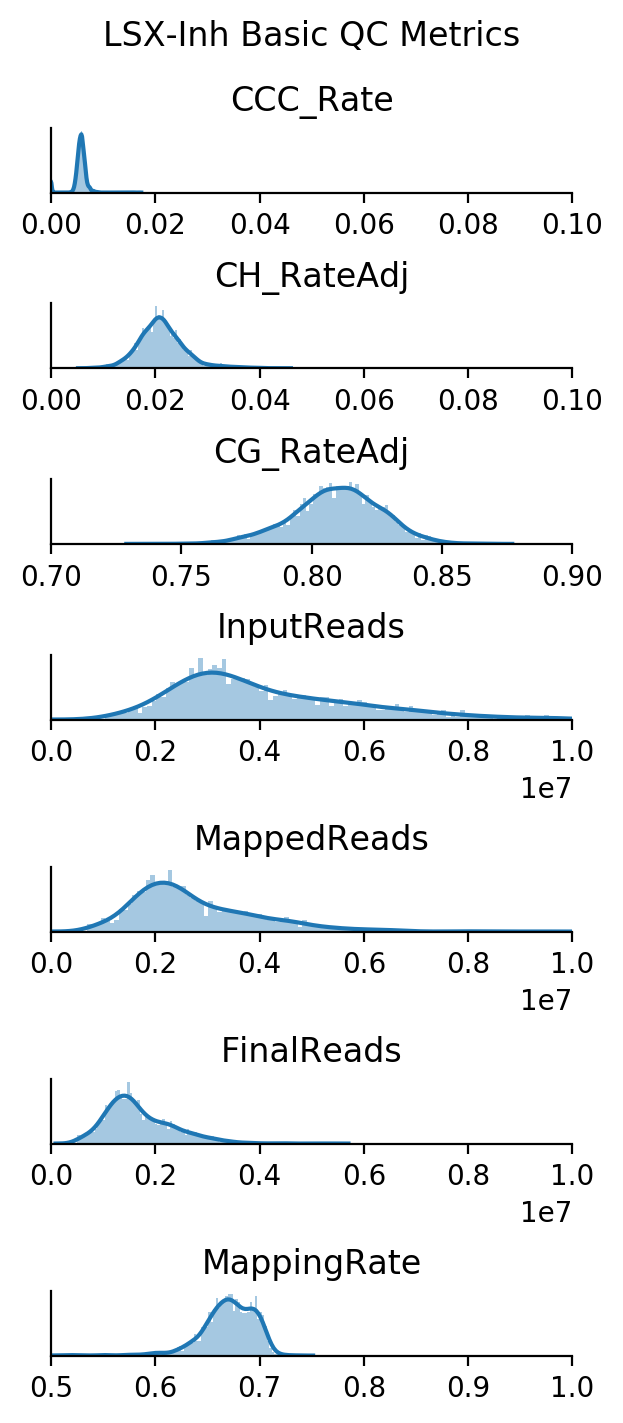

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

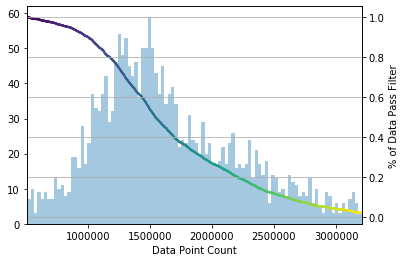

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2143/2143 (100.0%)
CG_RateAdj passed 2143/2143 (100.0%)
CH_RateAdj passed 2143/2143 (100.0%)
FinalReads passed 2143/2143 (100.0%)
MappingRate passed 2143/2143 (100.0%)
Overall passed 2143/2143 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180109 4
180110 22
180111 8
180212 1
180220 6
180222 8
180313 1
180326 2
180403 3
180405 2
180724 5
180806 19
180911 35
180917 588
181008 2
181015 26
181016 73
181204 512
181220 1
190108 1
190207 791
190711 8
190716 25


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 154 40.1%
ad002 289 75.3%
ad004 279 72.7%
ad006 279 72.7%
ad007 297 77.3%
ad008 296 77.1%
ad010 266 69.3%
ad012 283 73.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1C_M_1890,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.005080,0.786230,0.785140,0.021920,0.016930,1521067.0,3352892,2251638.0,1C,...,6.514551,1.252496,-16.821884,19.215488,LSX-Inh,-4.418705,2.372718,-29.525770,8.556096,True
2D_M_1716,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.005700,0.838300,0.837370,0.031810,0.026260,681018.0,1479788,960271.0,2D,...,7.561164,1.468583,-16.324343,20.489335,LSX-Inh,-5.263372,1.691731,-22.779602,10.974269,True
2D_M_2232,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.006270,0.827090,0.826000,0.036880,0.030800,1433785.0,3212358,2099426.0,2D,...,6.945451,1.542356,-16.386080,19.629919,LSX-Inh,-4.903427,1.750062,-25.046757,10.183642,True
2D_M_2349,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.006850,0.829910,0.828740,0.038780,0.032150,1713630.0,4439096,2887209.0,2D,...,6.900663,1.343059,-16.963867,19.869204,LSX-Inh,-4.972925,1.820546,-24.796925,10.254580,True
2D_M_324,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.006460,0.831060,0.829960,0.035920,0.029650,1855055.0,4180950,2779829.0,2D,...,6.970111,1.617840,-16.352657,19.518570,LSX-Inh,-4.791704,1.620405,-25.191868,10.276743,True
2E_M_1266,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.007600,0.862570,0.861520,0.039840,0.032490,908947.0,2357656,1465199.0,2E,...,7.592452,1.533786,-15.428100,20.550028,LSX-Inh,-5.164909,1.552098,-21.855088,11.177120,True
2E_M_128,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.006770,0.841110,0.840030,0.030600,0.023990,748630.0,2305932,1270971.0,2E,...,7.283511,1.888770,-15.057084,20.053074,LSX-Inh,-4.847585,1.507290,-29.509218,10.975604,True
2E_M_1304,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.006810,0.844830,0.843770,0.036620,0.030010,895344.0,2295944,1416744.0,2E,...,7.228153,1.871689,-15.348250,20.272506,LSX-Inh,-4.957636,1.735788,-29.515720,10.384651,True
2E_M_1398,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.006540,0.829080,0.827950,0.033510,0.027150,963988.0,2417236,1506023.0,2E,...,7.174212,1.685304,-15.486477,20.287575,LSX-Inh,-4.806339,1.983076,-29.524942,10.313424,True
